In [308]:
import pandas as pd

dfi = pd.read_csv("predict_intentions.csv").drop_duplicates()
dfi

,execution_id,nullify,cardinality
0,I-120-12-0,5.0,1164
1,I-120-12-1,5.0,2604
2,I-120-12-2,5.0,4044
6,I-120-12-3,5.0,5484
7,I-120-12-4,5.0,6924
8,I-120-12-5,5.0,8364
9,I-120-12-6,5.0,12684
10,I-120-12-7,5.0,15564
11,I-121-2-0,5.0,98
12,I-121-3-1,5.0,147


In [309]:
duplicated_values = dfi[dfi['execution_id'].duplicated(keep=False)]['execution_id'].unique()
print("Duplicated values:", duplicated_values)
dfi[dfi['execution_id'].isin(duplicated_values)]

Duplicated values: []


,execution_id,nullify,cardinality


In [310]:
dfm = pd.read_csv("predict_models.csv")
dfm

,execution_id,model,time
0,I-122-12-6,pivot,3
1,I-122-12-6,timeDecisionTree,25372
2,I-122-12-6,timeRandomForest,28008
3,I-122-12-6,univariateTS,286270
4,I-122-12-6,decisionTree,243
...,...,...,...
862,I-120-12-0,pivot,3
863,I-120-12-0,timeDecisionTree,26333
864,I-120-12-0,timeRandomForest,28975
865,I-120-12-0,decisionTree,231


In [311]:
dfc = pd.read_csv("predict_components.csv")
dfc["success_time"] = dfc.apply(lambda x: x["success_time"] if x["success_time"] > 0 else x["component_time"], axis=1)
dfc["component_time"] = dfc.apply(lambda x: ((x["success_time"] / x["success"]) * 21) if x["success"] > 0 else float('inf'), axis=1).astype(float)
dfc[dfc["model"] == "multivariateTS"] 

,model,component,interest,sparsity,endog,exog,component_time,success,success_time,execution_id
73,multivariateTS,ALL,-1.369326,0.041096,6,0,194544.000000,8,74112,I-122-6-4
93,multivariateTS,ALL,-1.696836,0.041096,5,0,360536.750000,12,206021,I-122-5-3
110,multivariateTS,ALL,-0.831785,0.041096,4,0,139496.000000,9,59784,I-122-4-2
124,multivariateTS,ALL,-1.513014,0.041096,3,0,19416.250000,12,11095,I-122-3-1
135,multivariateTS,ALL,-0.089233,0.041096,2,0,18951.545455,11,9927,I-122-2-0
...,...,...,...,...,...,...,...,...,...,...
2835,multivariateTS,ALL,-0.299512,0.040816,3,0,57368.500000,12,32782,I-121-3-1
2846,multivariateTS,ALL,-5.260986,0.040816,2,0,18702.250000,12,10687,I-121-2-0
2944,multivariateTS,ALL,-3.159265,0.040816,4,0,94066.875000,8,35835,I-121-4-2
2958,multivariateTS,ALL,-0.299512,0.040816,3,0,61372.500000,12,35070,I-121-3-1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


\begin{tabular}{lrrrrrrr}
\toprule
Intention & I0 & I1 & I2 & I3 & I4 & I5 & I6 \\
\midrule
$|C|$ & 1164 & 2604 & 4044 & 5484 & 6924 & 8364 & 12684 \\
Time (s) & 297.52 & 522.43 & 734.99 & 939.28 & 1059.31 & 1525.38 & 1913.33 \\
Interest & 0.96 & 0.93 & 0.91 & 0.94 & 0.66 & 0.93 & 0.78 \\
Predicted values & 58 & 130 & 202 & 274 & 346 & 418 & 634 \\
\bottomrule
\end{tabular}



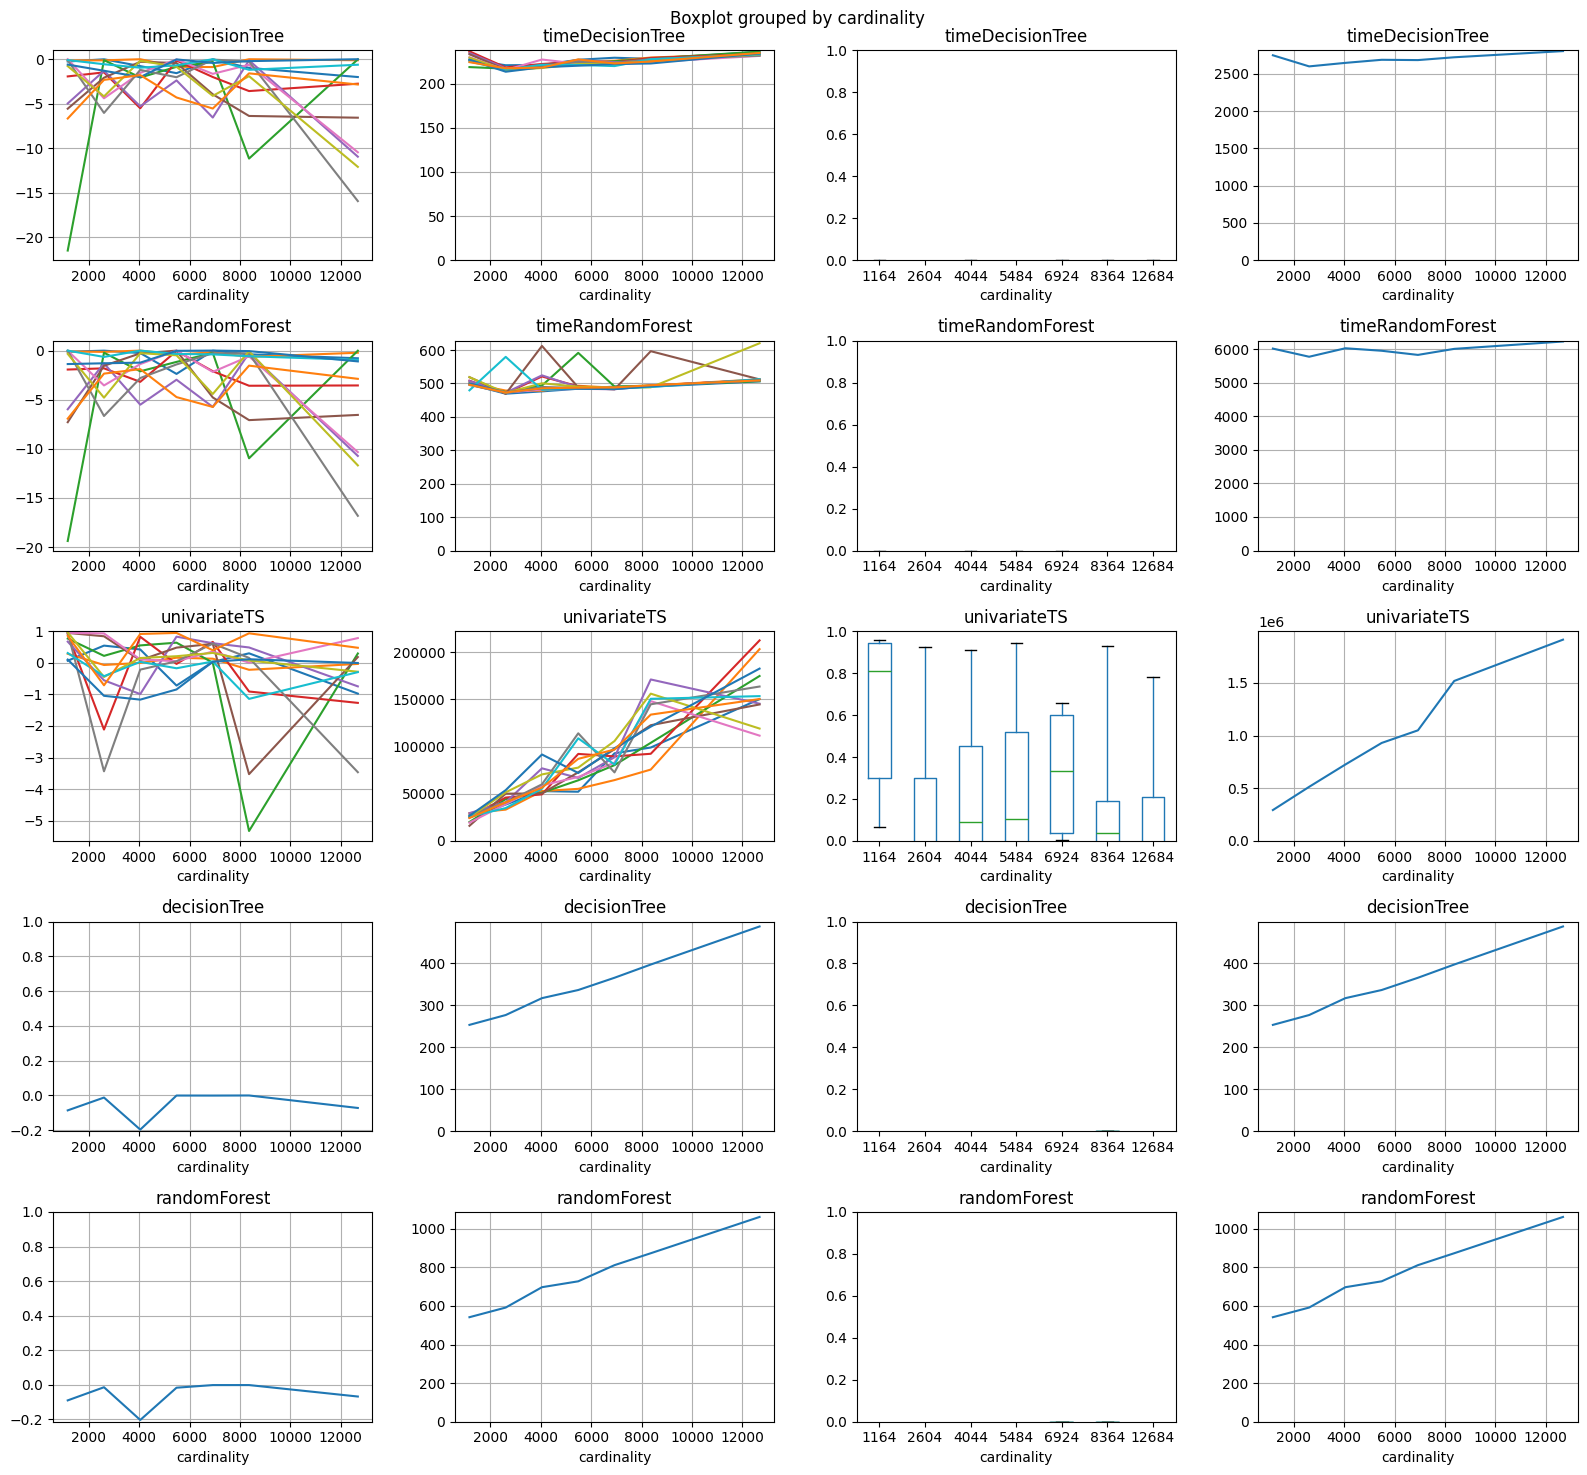

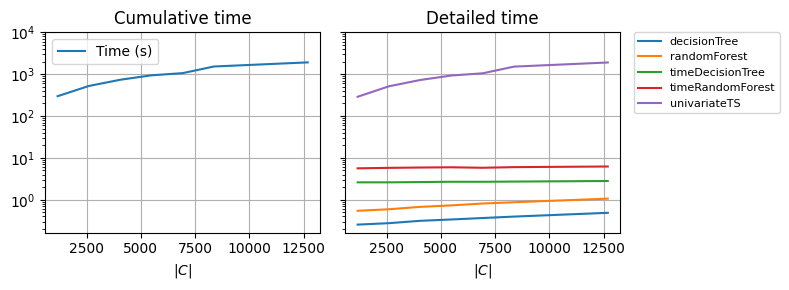

In [312]:
import matplotlib.pyplot as plt

def plot(s):
    filtered = dfc[dfc['execution_id'].str.contains(s)] #  & dfc['model'].isin(values_to_check) 
    values_to_check = filtered["model"].unique() # ["timeDecisionTree", "timeRandomForest", "univariateTS", "decisionTree", "randomForest", "multivariateTS"] 
    filtered = filtered.merge(dfi, on=["execution_id"])
    filtered = filtered.drop(filtered[(filtered['execution_id'].str.contains("-122-")) & (filtered['model'] == "multivariateTS") & (filtered['cardinality'] > 400)].index)
    filtered = filtered.drop(filtered[(filtered['execution_id'].str.contains("-120-")) & (filtered['cardinality'] > 14000)].index)
    
    fig, ax = plt.subplots(len(values_to_check), 4, figsize=(4 * 4, 3 * len(values_to_check)))
    ax = ax.flatten()
    df = filtered

    i = 0
    for v in values_to_check:
        odf = df[df["model"] == v]
    
        for c in odf["component"].unique():
            idf = odf[odf["component"] == c]
            idf = idf[["cardinality", "interest", "component_time"]].groupby("cardinality").mean().reset_index()
            idf.plot(ax=ax[i],     x="cardinality", y="interest", label=c)
            idf.plot(ax=ax[i + 1], x="cardinality", y="component_time", label=c)
        

        adf = odf[["component", "cardinality", "interest"]].groupby(["component", "cardinality"]).median().reset_index()
        adf.boxplot(ax=ax[i + 2], by="cardinality", column="interest")
        ax[i + 0].set_ylim([None, 1])
        ax[i + 2].set_ylim([0, 1])

        adf = odf[["component", "cardinality", "component_time"]].groupby(["component", "cardinality"]).mean().reset_index().groupby(["cardinality"]).sum().reset_index()
        # adf = odf[["component", "cardinality", "component_time"]].groupby(["cardinality"]).sum().reset_index()
        adf.plot(ax=ax[i + 3], x="cardinality", y="component_time")
        ax[i + 1].set_ylim(0)
        ax[i + 3].set_ylim(0)

        for j in range(0, 4): 
            ax[i + j].grid() 
            ax[i + j].legend().set_visible(False)
            ax[i + j].set_title(v)
        # ax[i].set_ylim([0, 1])
        
        i += 4

    fig.tight_layout()

    
    fig, axs = plt.subplots(1, 2, figsize=(8 * 1, 3 * 1), sharey=True)
    axs = axs.flatten()
    i = 0
    ax = axs[i + 1] 
    dff = df.groupby(["execution_id", "model", "component", "cardinality"]).median().reset_index().groupby(["model", "cardinality"]).agg({"component_time": "sum", "interest": "max"})
    dff = dff.reset_index()
    dff["cardinality"] = dff["cardinality"].astype(int)
    dff["Predicted values"] = (dff["cardinality"] * 0.05).astype(int)
    dff["component_time"] = dff["component_time"].astype(int) / 1000
    dff = dff.rename({"cardinality": "$|C|$", "component_time": "Time (s)", "interest": "Interest", "model": "Model"}, axis=1)
    models = sorted(dff["Model"].unique())
    if "multivariateTS" in models:
        models = [x for x in models if x != "multivariateTS"] 
        models = models + ["multivariateTS"] 
    for model in models:
        dff[dff["Model"] == model].plot(x="$|C|$", y="Time (s)", kind="line", ax=ax, label=model) 
    ax.set_yscale('log')
    ax.set_yticks([1, 10, 100, 1000, 10000])
    ax.set_title("Detailed time")
    ax.grid()
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)

    ax = axs[i] 
    dff = dff.groupby(["$|C|$"]).agg({"Time (s)": "sum", "Interest": "max"})
    dff = dff.reset_index()
    dff["Predicted values"] = (dff["$|C|$"] * 0.05).astype(int)
    dff["Intention"] = range(0, len(dff))
    dff["Intention"] = "I" + dff["Intention"].astype(str)
    dff.index = dff["Intention"]
    dff = dff.drop("Intention", axis=1)
    dff.plot(x="$|C|$", y="Time (s)", kind="line", ax=ax)
    ax.set_yscale('log')
    ax.legend(loc=2)
    ax.set_yticks([1, 10, 100, 1000, 10000])
    ax.set_title("Cumulative time")
    ax.grid()
    fig.tight_layout()

    fig.savefig(f"{s}.svg")
    fig.savefig(f"{s}.pdf")
    print(dff.transpose().to_latex(float_format="{:.2f}".format).replace(".00", ""))# 
    
    
plot('-120-')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


\begin{tabular}{lrrrrrrr}
\toprule
Intention & I0 & I1 & I2 & I3 & I4 & I5 & I6 \\
\midrule
$|C|$ & 146 & 219 & 292 & 365 & 438 & 657 & 876 \\
Time (s) & 67.69 & 137.32 & 184.33 & 474.20 & 133.86 & 209.47 & 267.25 \\
Interest & 0.91 & 0.91 & 0.91 & 0.91 & 0.91 & 0.99 & 0.99 \\
Predicted values & 7 & 10 & 14 & 18 & 21 & 32 & 43 \\
\bottomrule
\end{tabular}



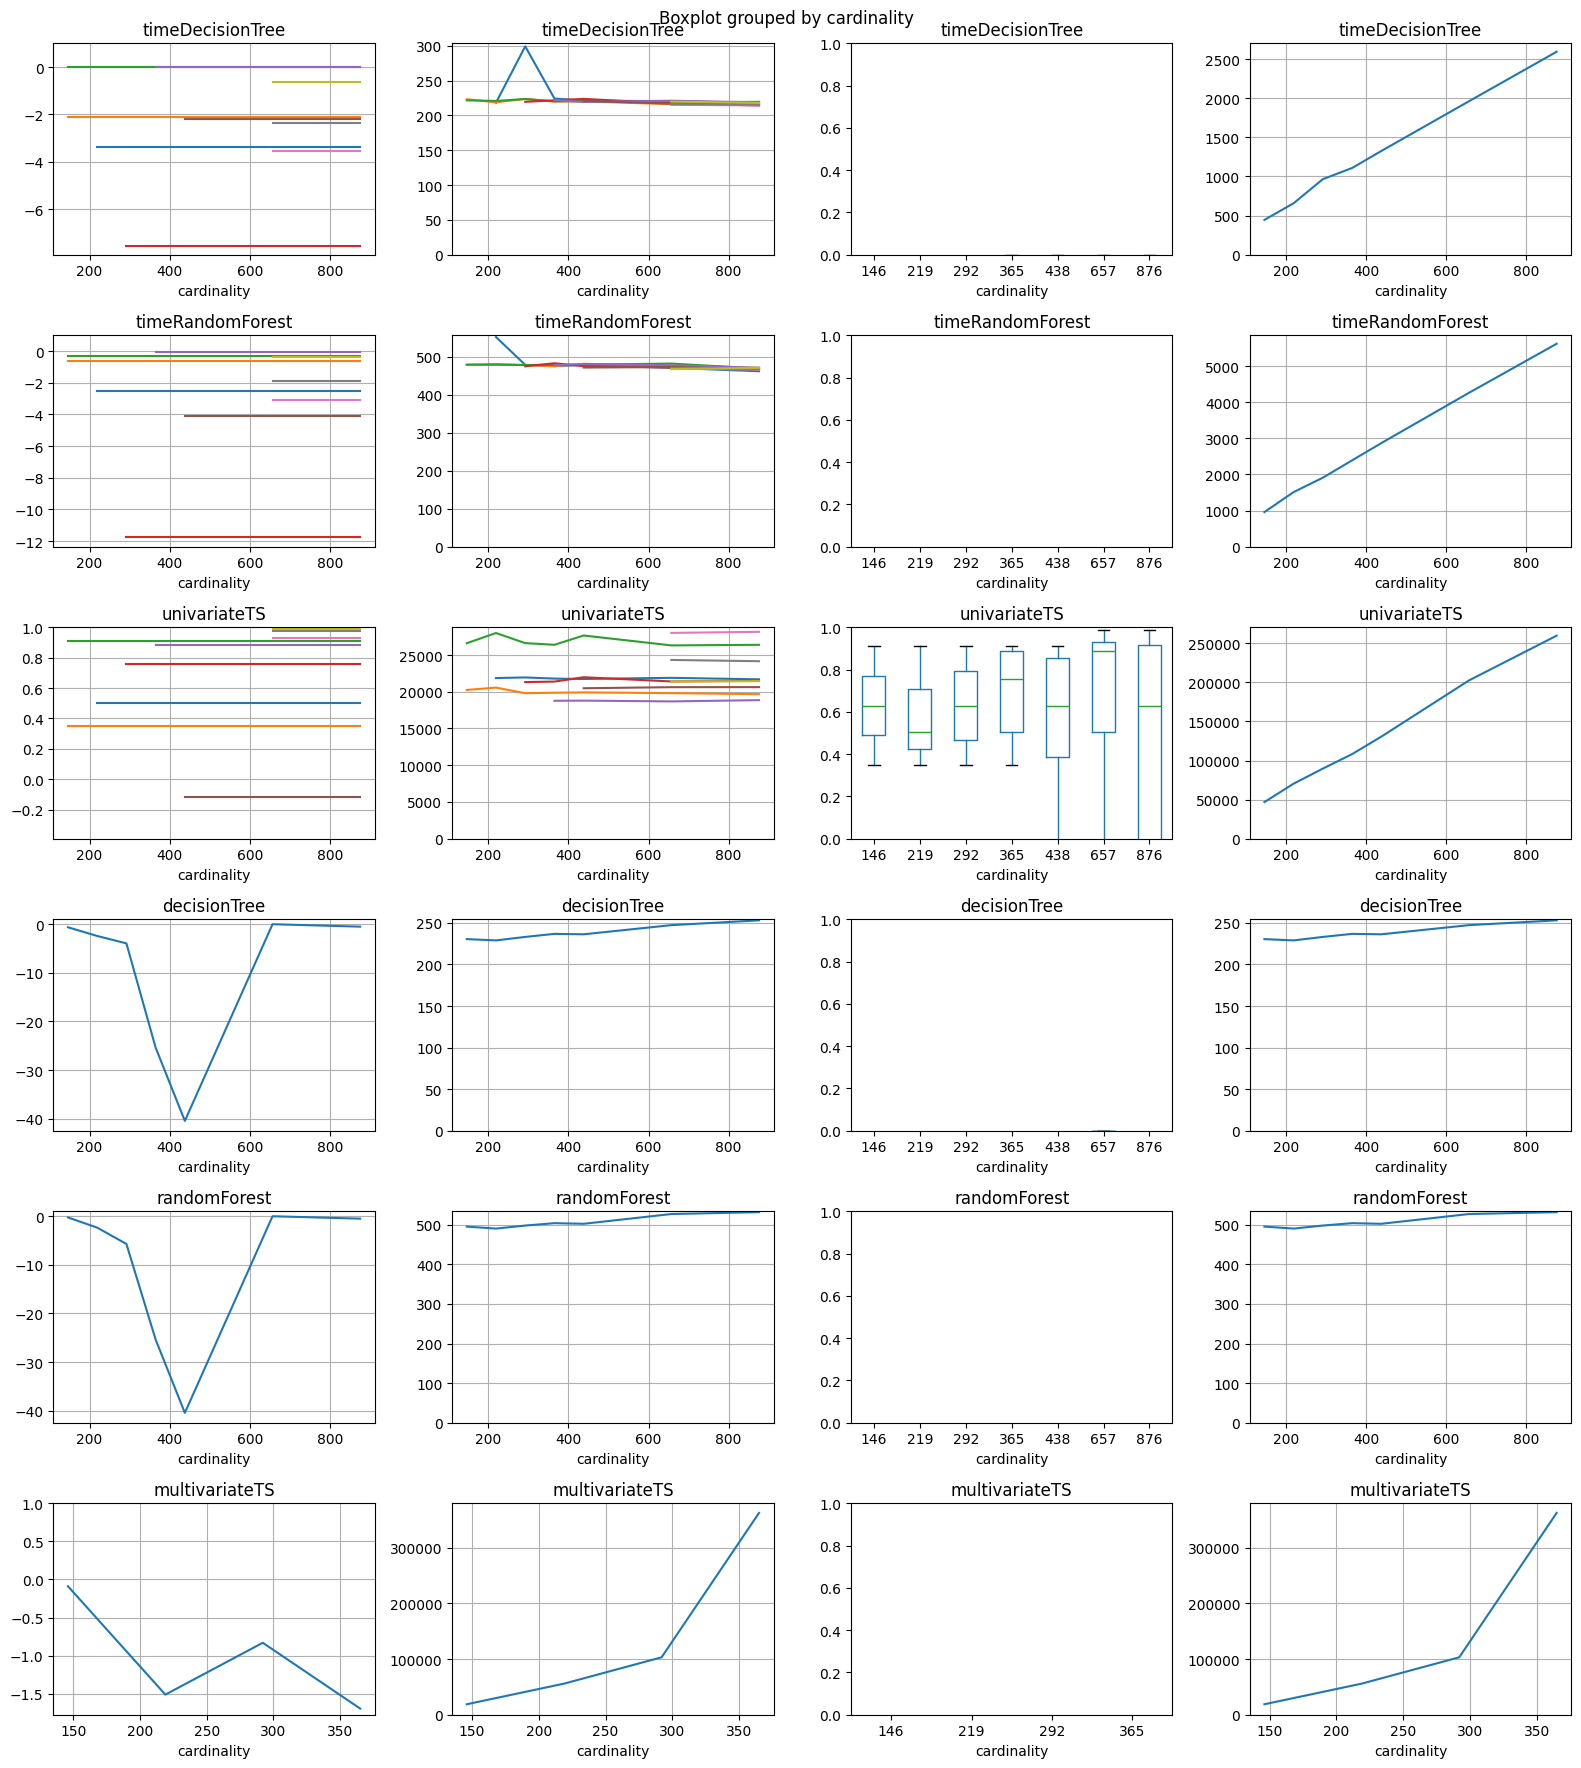

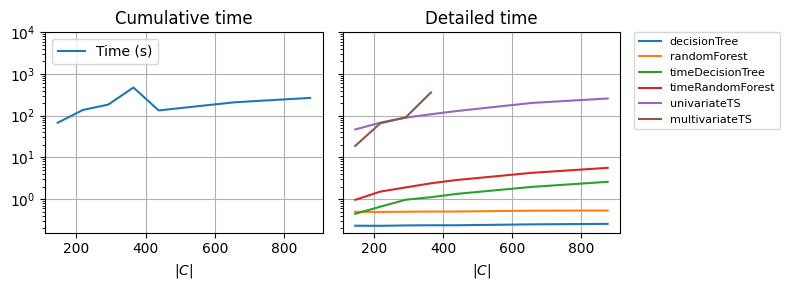

In [313]:
plot('-122-')